### ÍNDICE

- [0. Imports](#0-imports)
- [1. Carga datos](#1-carga-datos)
- [2. Problema Machine Learning](#2-problema-machine-learning)
- [3. Divide en train y test](#3-divide-en-train-y-test)
- [4. Target](#4-target)
- [5. Comprensión de variables](#5-comprensión-de-variables)
- [6. Feat. Red. Preliminar](#6-feat-red-preliminar)
- [7. Feature Engineering](#7-feature-engineering)
- [8. Missings y Eliminación de Features](#8-missings-y-eliminación-de-features)
- [9. Análisis univariante](#9-análisis-univariante)
- [10. Análisis Bivariante](#10-análisis-bivariante)
- [11. Outliers](#11-outliers)
- [12. Escoger Métrica del Modelo](#12-escoger-métrica-del-modelo)
- [13. Decidir el Modelo](#13-decidir-el-modelo)
- [14. Definimos Pipelines y Probamos](#14-definimos-pipelines-y-probamos)
- [15. Resultados](#15-resultados)
 


# 0. Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
# Procesamiento
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVC
# Validación y Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV
# Métricas
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Carga datos

In [2]:
# Cargo el dataset en un DataFrame

df_raw = pd.read_csv('./src/data_sample/amazon_best_sellers_2025_01_27.csv')

# 2. Problema Machine Learning

Antes de empezar el curso estuve investigando sobre la opción de abrir una tienda en Amazon y un problema con el que me encontré es qué vender. Por eso, quiero plantear una solución basada en Machine Learning que pueda predecir el precio esperado para un producto en función de su contexto (categoría, marca, rating, etc...), con el objetivo de poder evitar aquellos productos cuya estimación se aleje del precio al que pudiera venderlos. El objetivo es tener una estimación de qué precio necesitaría un producto para venderse y comprobar si para mi sería viable venderlo a ese precio.

**Sería un problema de regresión porque el objetivo es predecir un valor numérico, no una categoría.**

# 3. Divide en train y test

In [3]:
# - Antes de dividir train y test, como el dataset tiene 2 columnas de precios y yo quiero definir una como target, voy a tratarlas para convertirlas en una nueva y usarla como target.
# - Las columnas con precios son listedPrice (precio normal) y salePrice (precio de oferta).
# - Quiero como target listedPrice. Como la columna contiene nulos, voy a unirla con salePrice solo para intentar cubrir alguno de esos nulos. Interpreto que donde no hay listedPrice es porque son productos
#   que entraron en los más vendidos vendiendo solo a través de ofertas, esto creo que convierte al precio de oferta en el precio real del producto y se puede pasar directamente a listedPrice.

df_raw['price'] = df_raw['listedPrice'].combine_first(df_raw['salePrice']) # Combino las columnas en una nueva priorizando listedPrice


# Aprovecho y elimino las filas con nulos en price ya que si no tengo el precio con esas columnas no puedo hacer nada.

df_raw = df_raw.dropna(subset = ['price'])


In [4]:
# Hago el split de train y test, dejando un 30% para test

X_train, X_test, y_train, y_test = train_test_split(df_raw.drop('price', axis=1),
                                                    df_raw['price'],
                                                    test_size=0.3,
                                                    random_state=40)

# 4. Target



Text(0.5, 1.0, 'power2')

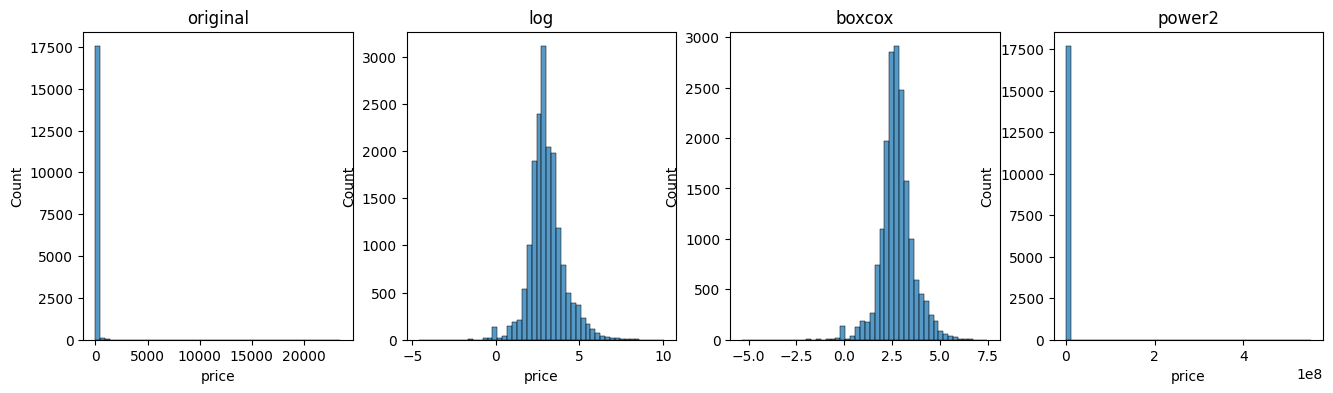

In [5]:
# Saco gráficos para comprobar si puede merecer la pena aplicar una transformación de los datos

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.histplot(y_train, bins=50, ax=axes[0]).set_title("original")
sns.histplot(np.log(y_train), bins=50, ax=axes[1]).set_title("log")
sns.histplot(stats.boxcox(y_train)[0], bins=50, ax=axes[2]).set_title("boxcox")
sns.histplot(np.power(y_train, 2), bins=50, ax=axes[3]).set_title("power2")

In [6]:
cero = np.sum(y_train == 0)
cero

np.int64(0)

In [7]:
# Parece que log y boxcox podrían ser buenas opciones para aplicar, pero quiero comprobar cual seria mejor, visualmente parecen muy similares
log = np.log1p(y_train)
boxcox, lam = stats.boxcox(y_train)

for name, vec in {'orig':y_train, 'log':log, 'boxcox':boxcox}.items():
    print(f'\n{name.upper()}')
    print('skew:', stats.skew(vec))
    print('kurt:', stats.kurtosis(vec, fisher=True))
    print('shapiro:', stats.shapiro(vec).pvalue)


ORIG
skew: 65.59604393088034
kurt: 6042.232834749758
shapiro: 9.94308663180579e-130

LOG
skew: 0.8112556634746558
kurt: 2.38618039433054
shapiro: 3.0566019971971214e-58

BOXCOX
skew: -0.06444516558641568
kurt: 3.33985956091532
shapiro: 1.2678709653723637e-55


c:\Users\hugof\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17675.
  res = hypotest_fun_out(*samples, **kwds)


In [8]:
# - Boxcox es la que mejor veo, asi que me quedo con esa
# - Hago una nueva columna donde aplico la transformación
y_train_boxcox, mi_lambda = stats.boxcox(y_train)

print(f'lambda usado para transformar despues: {mi_lambda}') # -0.06186567113028077


lambda usado para transformar despues: -0.06186567113028077


In [9]:
# Aplico la transformacion a test

y_test_boxcox = stats.boxcox(y_test, mi_lambda)


# Reasigno variables por comodidad

y_train = y_train_boxcox
y_test = y_test_boxcox

# 5. Comprensión de variables



In [10]:
# Análisis inicial sencillo 

df_raw.describe(include='all')
df_raw.info()


# Dimensiones del dataset

print("Filas:", df_raw.shape[0])
print("Columnas:", df_raw.shape[1])

<class 'pandas.core.frame.DataFrame'>
Index: 25251 entries, 0 to 25873
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   additionalProperties  25225 non-null  object 
 1   brandName             23302 non-null  object 
 2   breadcrumbs           25071 non-null  object 
 3   color                 11081 non-null  object 
 4   currency              25251 non-null  object 
 5   current_depth         25251 non-null  int64  
 6   description           25250 non-null  object 
 7   descriptionRaw        25251 non-null  object 
 8   features              18721 non-null  object 
 9   gtin                  9036 non-null   object 
 10  imageUrls             25249 non-null  object 
 11  inStock               20515 non-null  object 
 12  listedPrice           14806 non-null  float64
 13  material              10179 non-null  object 
 14  mpn                   12395 non-null  object 
 15  name                  25

### **NOTA: Por dejar más limpio el notebook principal, las comprobaciones mas concretas de cada columna las dejo en (src\notebooks\pruebas.ipynb), a continuación reflejo un resumen basado en las conclusiones a las que llegué**

### Información sobre las columnas


| **Columna**            | **Descripción**                                                                                 |
| ---------------------- | ----------------------------------------------------------------------------------------------- |
| `additionalProperties` | Características del producto desde un punto de vista más técnico                                |
| `brandName`            | Nombre de la marca                                                                              |
| `breadcrumbs`          | Subategorías del producto                                                                       |
| `color`                | Color del producto                                                                              |
| `currency`             | Moneda (todo está en USD)                                                                       |
| `current_depth`        | Categorías internas de Amazon                                                                   |
| `description`          | Descripción de los productos                                                                    |
| `descriptionRaw`       | Descripción de los productos en formato HTML                                                    |
| `features`             | Características de los productos de forma más descriptiva                                       |
| `gtin`                 | Identificador global único del producto (Global Trade Item Number)                              |
| `imageUrls`            | URLs de las imágenes de los productos                                                           |
| `inStock`              | Indica si está en stock (`TRUE` hay, `FALSE` no hay)                                            |
| `listedPrice`          | Precio del producto                                                                             |
| `material`             | Material del que está hecho el producto                                                         |
| `mpn`                  | Identificador del producto según el fabricante                                                  |
| `name`                 | Nombre del producto                                                                             |
| `new_path`             | Nueva categoría donde se encuentra el producto (ej. Hogar, Accesorios, Electrodomésticos, etc.) |
| `nodeName`             | Nombre de la categoría (parece similar a `new_path`)                                            |
| `rating`               | Rating del producto (escala de 1 a 5, con saltos de 0.1)                                        |
| `reviewCount`          | Número de reviews                                                                               |
| `salePrice`            | Precio de oferta (algunos productos solo tienen este precio)                                    |
| `scrapedDate`          | Fecha en la que se scrapeó la información                                                       |
| `size`                 | Tamaño del producto (con mucha variabilidad en el formato)                                      |
| `sku`                  | Código interno de Amazon para identificar el producto                                           |
| `style`                | Estilo del producto (gran variedad, datos incompletos y sin categorías definidas)               |
| `url`                  | URL del producto                                                                                |
| `variants`             | Opciones del producto (modelo, tamaño, color, etc.)                                             |
| `weight_rawUnit`       | Unidad de medida del peso (similar a `weight_unit`)                                             |
| `weight_unit`          | Unidad de medida del peso (similar a `weight_rawUnit`)                                          |
| `weight_value`         | Peso del producto                                                                               |
| `price`                | Lista de precios unificada                                                                      |
| `price_boxcox`         | Columna price con Box-Cox aplicado                                                              |

##### Columnas a modificar:

**new_path → category:**
Se transforma en una nueva columna que recoge únicamente la categoría principal, con el objetivo de reducir la dimensionalidad y poder tratarla como categórica.

**variants → has_variants:**
Dado que un 60% de los productos no tienen variantes, se transforma en una variable booleana que indica si el producto ofrece opciones o no.

# 6. Feat. Red. Preliminar



##### Columnas a eliminar:

**additionalProperties, color, features, size, style, weight_unit, weight_value, material, name:**
Estas columnas contienen información específica del producto, que solo sería útil si comparásemos productos dentro de una misma categoría. Dado que el dataset contempla todo tipo de productos, no aportan valor relevante este análisis.

**currency:**
Tiene un único valor representado (USD) y contiene nulos. No es posible verificar el contenido original de los valores nulos, y al no haber variabilidad, se descarta.

**current_depth, gtin, mpn, scrapedDate, sku, url:**
Son identificadores o datos referentes al scraping. No son necesarios para el análisis, ya que no aportan información relevante al modelo.

**description, descriptionRaw, imageUrls:**
Textos descriptivos o HTML que presentan valores prácticamente únicos. No sé como podría tratar esta columna para tenerla en cuenta, creo que puede ser relvante para cosas como palabras clave, pero la descarto porque para poder analizarla correctamente creo que es necesario Deep Learning.

**inStock:**
Indica si el producto estaba en stock en el momento del scraping, creo que sería útil para ver si es algo que sigue vendiendo pero la información no está suficientemente actualizada.

**nodeName, weight_rawUnit, breadcrumbs:**
Columnas redundantes o duplicadas respecto a otras. No aportan información adicional útil.

**listedPrice, salePrice, price:**
Columnas tratadas para conseguir el target, no es necesario mantenerlas.

In [11]:
# Elimino columnas innecesarias

drop_columns = ['additionalProperties', 'color', 'features', 'size', 'style', 'name', 'weight_unit', 'weight_value', 'material', 
                'currency', 'current_depth', 'gtin', 'mpn', 'scrapedDate', 'sku', 'url', 'description', 'descriptionRaw', 'imageUrls', 
                'inStock', 'nodeName', 'weight_rawUnit', 'breadcrumbs', 'listedPrice', 'salePrice']

X_train.drop(columns=drop_columns, inplace=True)
X_test.drop(columns=drop_columns, inplace=True)

# 7. Feature Engineering


Antes de hacer el análisis, quiero tratar las columnas categoricas, se dividen en muchas categorías y ni es práctico que haya tantas ni se puede entender nada de las visualizaciones

##### Columnas a modificar:


**new_path → category:**
Se transforma en una nueva columna que recoge únicamente la categoría principal, con el objetivo de reducir la dimensionalidad y poder tratarla como categórica.

**variants → has_variants:**
Dado que un 60% de los productos no tienen variantes, se transforma en una variable booleana que indica si el producto ofrece opciones o no.

**brandName → brand:**
Se limita el número de marcas que se tendrán en cuenta.

In [12]:
# Primero trato new_path
# Como hay muchas subcategorías, voy a ajustar la columna para que solo guarde la categoría principal y reducir así el número de categorías

# Creo una columna nueva cogiendo el valor hasta el primer >, quedandose con la primera parte y con todo si no encuentra nada
X_train['category'] = X_train['new_path'].str.split(">").str[0].str.strip()
X_test['category'] = X_test['new_path'].str.split(">").str[0].str.strip()  

In [13]:
# Trato también la columna variants. Voy a tener en cuenta el hecho de si tienen categorías o no, dejando 1 donde tenga y 0 donde no

X_train['has_variants'] = X_train['variants'].notna().astype('Int8')
X_test['has_variants'] = X_test['variants'].notna().astype('Int8')


In [14]:
# Por último trato la columna brandName, creo una columna donde haré todas las modificaciones

X_train['brand'] = X_train['brandName']
X_test['brand'] = X_test['brandName']


# Elimina 'Brand:' de algunas de las marcas

X_train['brand'] = X_train['brandName'].str.replace(r'(?i)^.*brand:\s*', '', regex=True).str.strip()
X_test['brand'] = X_test['brandName'].str.replace(r'(?i)^.*brand:\s*', '', regex=True).str.strip()


# Algunos valores son números, por lo que elimino los números
# Hago una máscara para ver cuáles son numéricos

mask_numeric = pd.to_numeric(X_train['brand'], errors='coerce').notna()


# Convierto a series y_train para poder tener un indice con el que borrar las mismas filas de X en Y

y_train = pd.Series(y_train, index=X_train.index)
index_mask = X_train[mask_numeric].index # guardo la máscara en una variable para que no haya problemas cuando dropee de Y por haber dropeado antes en X


# Elimino las filas con numéricos

X_train.drop(index=index_mask, inplace=True)
y_train.drop(index=index_mask, inplace=True)


In [15]:
# Haciendo pruebas, la mejor manera de tratar esta columna creo que es simplemente teniendo en cuenta un número de marcas limitado dentro de las más representadas. Intenté categorizarlas de otra manera
# pero todas acababan overfitteando el modelo, esta es la que mejor resultados me dio.

valcount = X_train['brand'].value_counts()
brands_7 = valcount[valcount >= 7].index # sacar las que aparecen 7 veces o mas

X_train = X_train[X_train['brand'].isin(brands_7)]

y_train = pd.Series(y_train, index=X_train.index)
y_train = y_train.loc[X_train.index]

In [16]:
# Aplico las modificaciones necesarias a test

mask_test = X_test['brand'].isin(brands_7)

X_test = X_test[mask_test]
y_test = y_test[mask_test.to_numpy()]

# 8. Missings y Eliminación de Features

Junto estos dos pasos porque quiero utilizar brandName como guía, al categorizarlo eliminé muchos nulos y se agruparon como categoría, quiero eliminar las filas donde haya nulos según brandName

In [17]:
# Elimino columnas que ya no necesito, tampoco necesito brandName pero como quiero evitar haber quitado nans al transformar columnas, quiero eliminar las filas donde tenga nulos

drop_columns = ['new_path', 'variants', 'brandName']
X_train.drop(columns = drop_columns, inplace = True)
X_test.drop(columns = drop_columns, inplace = True)

In [18]:
# Son pocas filas con nulos, así que los elimino
# - Hago una máscara para eliminar las filas que vaya a eliminar de X_train, borrarlas también en y_train
mask_index = X_train.notna().all(axis=1) # Hago una máscara para ver cuales son nulos
X_train.drop(index=X_train.index[~mask_index], inplace=True) # Invierto la máscara para eliminar los nulos
y_train = y_train[mask_index] # Aplico la primera máscara a y_train para conservar mismo número de filas

# 9. Análisis univariante




desc de 'rating':
count    1989.000000
mean        4.507793
std         0.329112
min         1.000000
25%         4.400000
50%         4.600000
75%         4.700000
max         5.000000
Name: rating, dtype: float64


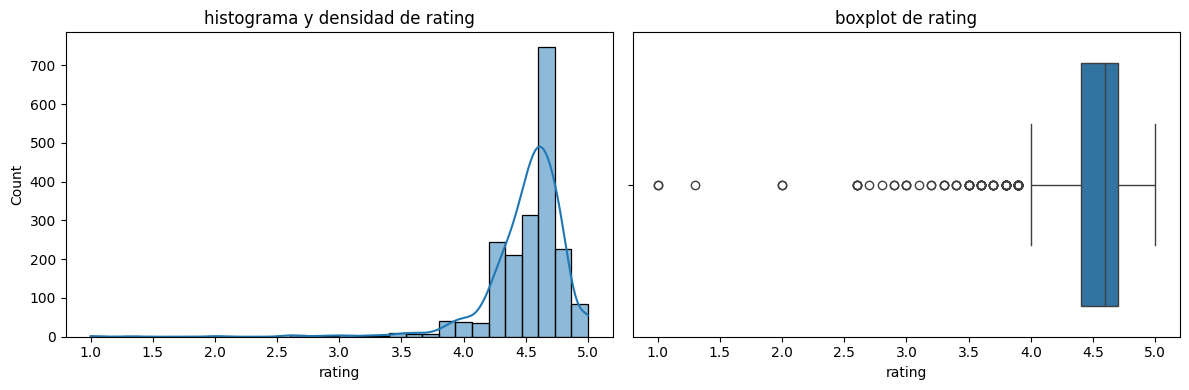


desc de 'reviewCount':
count      1989.000000
mean      10014.324786
std       36628.969246
min           1.000000
25%         191.000000
50%        1227.000000
75%        6809.000000
max      834243.000000
Name: reviewCount, dtype: float64


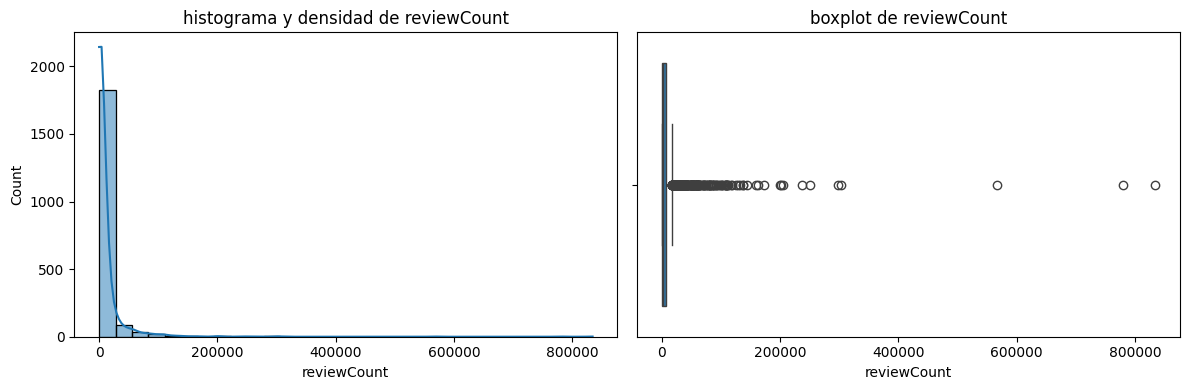


frecuencia de valores en 'category':
category
Clothing, Shoes & Jewelry       543
Sports & Outdoors               291
Automotive                      245
Books                           164
Industrial & Scientific         162
Audible Books & Originals        70
Grocery & Gourmet Food           65
CDs & Vinyl                      64
Kindle Store                     57
Office Products                  45
Electronics                      31
Health & Household               30
Kitchen & Dining                 30
Toys & Games                     28
Home & Kitchen                   27
Musical Instruments              24
Patio, Lawn & Garden             20
Amazon Devices & Accessories     12
Pet Supplies                     11
Movies & TV                      10
Cell Phones & Accessories        10
Baby                              9
Video Games                       8
Tools & Home Improvement          8
Arts, Crafts & Sewing             5
Beauty & Personal Care            5
Computers & Acces

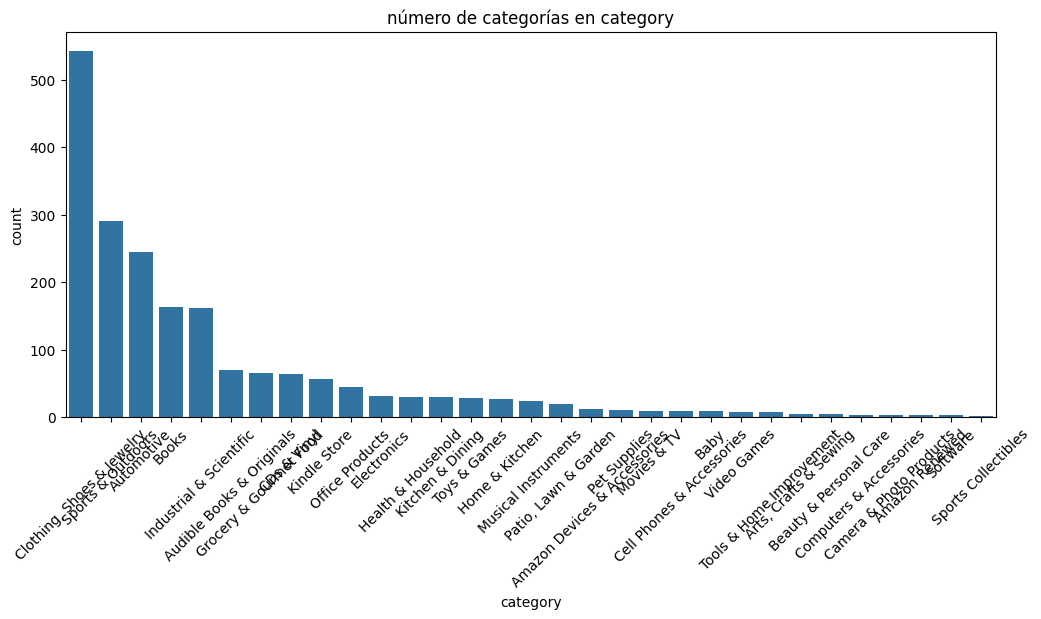


frecuencia de valores en 'brand':
brand
.us                           768
Audible Logo                  122
Amazon Music Curated Picks     64
Amazon Basics                  56
Generic                        51
                             ... 
Motorcraft                      6
Edelbrock                       6
Microsoft                       6
PRIME-LINE                      6
Small Parts                     4
Name: count, Length: 89, dtype: int64


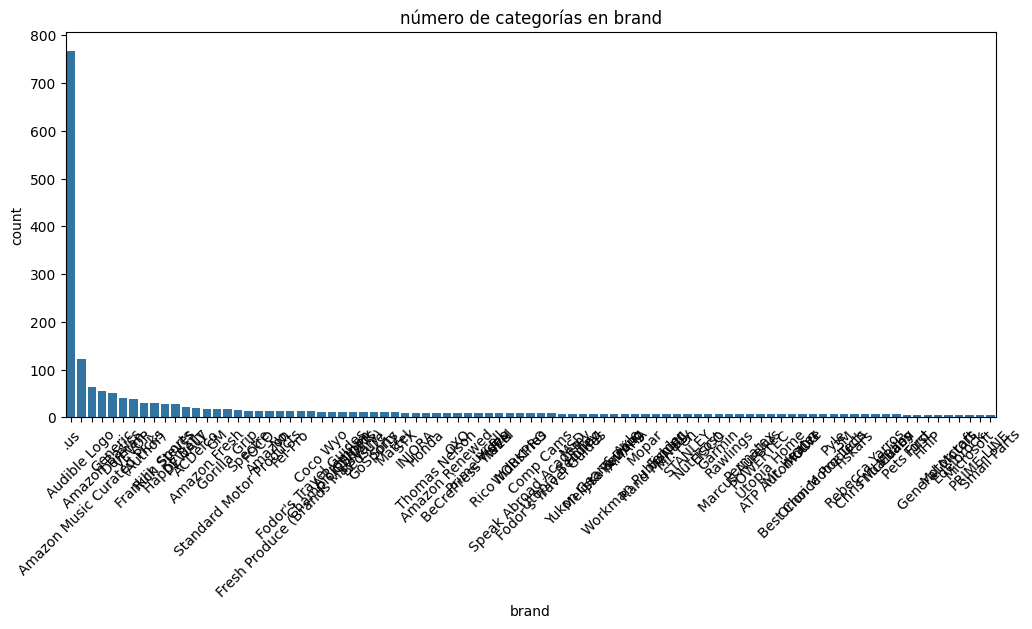


número de valores en 'has_variants':
has_variants
1    1104
0     885
Name: count, dtype: Int64


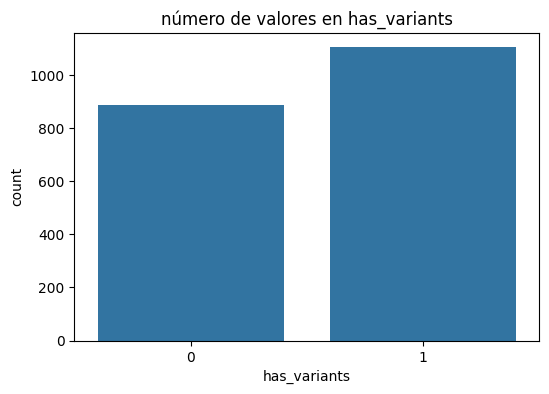

In [19]:
# Análisis para rating y reviewCount (Numéricas)

for col in ['rating', 'reviewCount']:
    print(f"\ndesc de '{col}':")
    print(X_train[col].describe())
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f'histograma y densidad de {col}')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=X_train[col])
    plt.title(f'boxplot de {col}')
    
    plt.tight_layout()
    plt.show()


# Análisis para category y brand (Categóricas)

for col in ['category', 'brand']:
    print(f"\nfrecuencia de valores en '{col}':")
    print(X_train[col].value_counts())
    
    plt.figure(figsize=(12,5))
    
    sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index)
    plt.title(f'número de categorías en {col}')
    plt.xticks(rotation=45)
    plt.show()
    

# análisis para has_variants

print("\nnúmero de valores en 'has_variants':")
print(X_train['has_variants'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x=X_train['has_variants'])
plt.title('número de valores en has_variants')
plt.show()

# 10. Análisis Bivariante



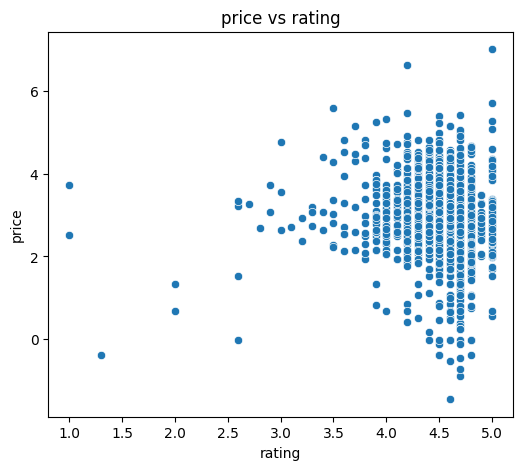

corr pearson: -0.077 (p-valor: 0.001)


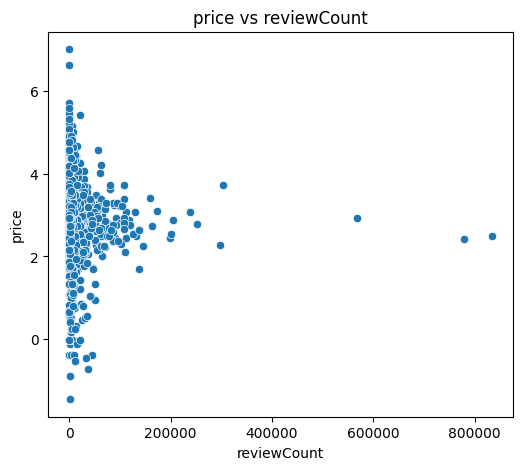

corr pearson: -0.034 (p-valor: 0.130)


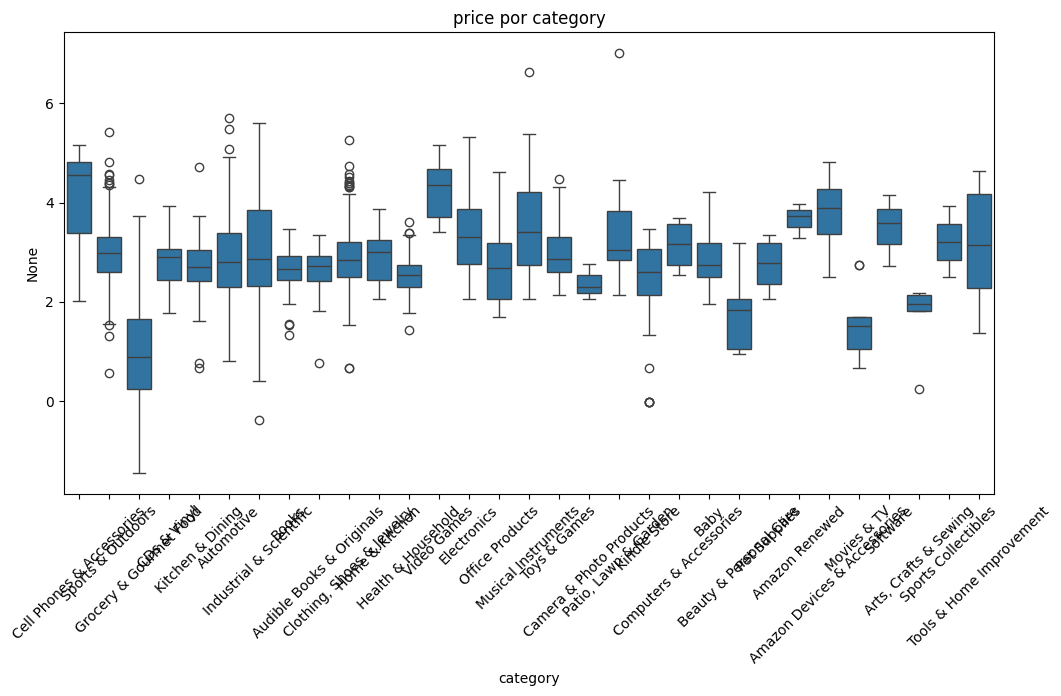

ANOVA p-valor para precio/category: 0.00000


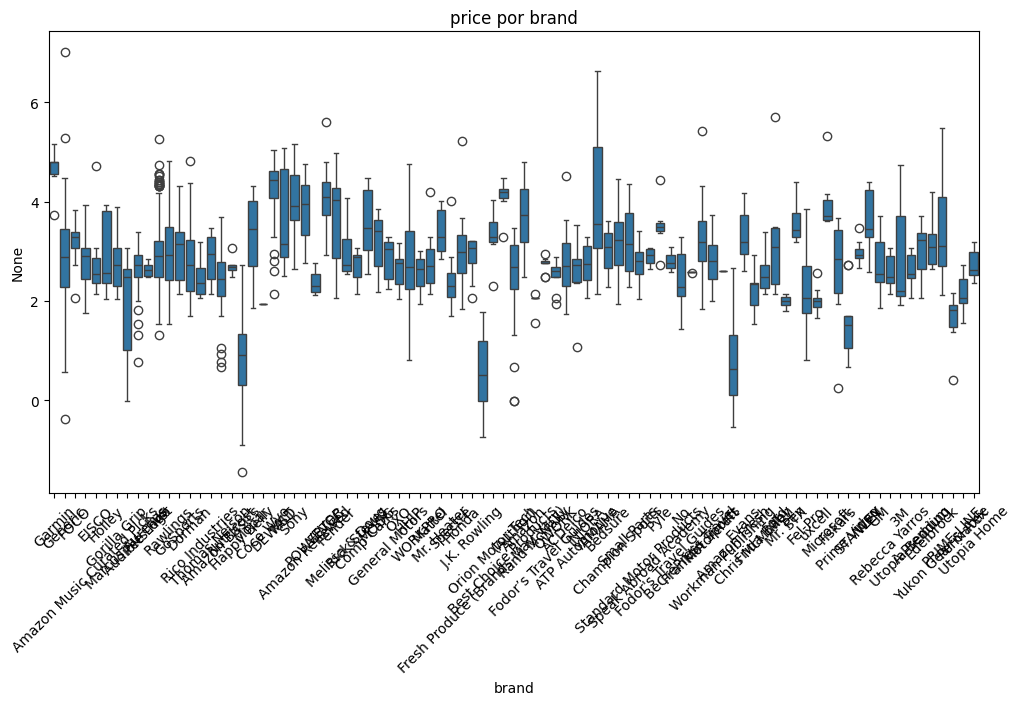

ANOVA p-valor para precio/brand: 0.00000


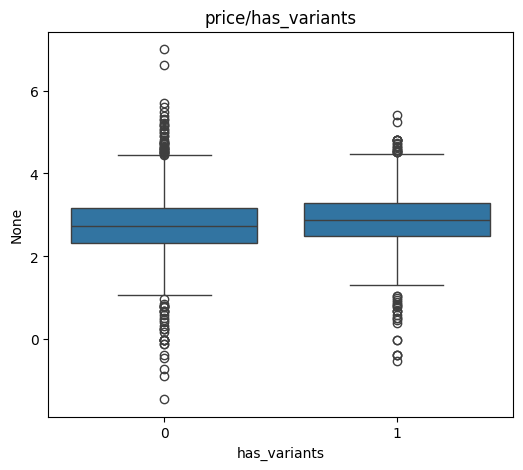

test t para precio/has_variants: t=3.130, p-valor=0.00178


In [20]:
# price vs rating 

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_train['rating'], y=y_train)
plt.title('price vs rating')
plt.xlabel('rating')
plt.ylabel('price')
plt.show()

# corr pearson
pearson_corr, p_value = stats.pearsonr(X_train['rating'], y_train)
print(f"corr pearson: {pearson_corr:.3f} (p-valor: {p_value:.3f})")

# price vs reviewCount

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_train['reviewCount'], y=y_train)
plt.title('price vs reviewCount')
plt.xlabel('reviewCount')
plt.ylabel('price')
plt.show()

# corr pearson
pearson_corr_rc, p_value_rc = stats.pearsonr(X_train['reviewCount'], y_train)
print(f"corr pearson: {pearson_corr_rc:.3f} (p-valor: {p_value_rc:.3f})")

# price vs category

plt.figure(figsize=(12,6))
sns.boxplot(x=X_train['category'], y=y_train)
plt.title('price por category')
plt.xticks(rotation=45)
plt.show()

# ANOVA
anova_result = stats.f_oneway(*(y_train[X_train['category'] == cat] for cat in X_train['category'].unique()))
print(f"ANOVA p-valor para precio/category: {anova_result.pvalue:.5f}")

# price vs brand

plt.figure(figsize=(12,6))
sns.boxplot(x=X_train['brand'], y=y_train)
plt.title('price por brand')
plt.xticks(rotation=45)
plt.show()

anova_result_bc = stats.f_oneway(*(y_train[X_train['brand'] == cat] for cat in X_train['brand'].unique()))
print(f"ANOVA p-valor para precio/brand: {anova_result_bc.pvalue:.5f}")


# price vs has_variants (numérico vs booleano)

plt.figure(figsize=(6,5))
sns.boxplot(x=X_train['has_variants'], y=y_train)
plt.title('price/has_variants')
plt.show()

# Test t de Student para diferencia de medias
grupo_true = y_train[X_train['has_variants'] == True]
grupo_false = y_train[X_train['has_variants'] == False]

t_stat, p_val = stats.ttest_ind(grupo_true, grupo_false, equal_var=False)
print(f"test t para precio/has_variants: t={t_stat:.3f}, p-valor={p_val:.5f}")

# 11. Outliers

In [21]:
# Después de probar a limitar y a eliminar los outliers, veo que limitándolos funciona mejor el modelo

Q1 = np.percentile(y_train, 25)
Q3 = np.percentile(y_train, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

y_train_capped = y_train.copy()
y_train[y_train < lower_bound] = lower_bound
y_train[y_train > upper_bound] = upper_bound


# Me aseguro de que no haya nulos

mask = ~X_test.isna().any(axis=1)
X_test = X_test.loc[mask]
y_test = y_test[mask]

# 12. Escoger Métrica del Modelo




In [22]:
X_train = pd.get_dummies(X_train) # Hago one hot encoding de las categoricas
X_test = pd.get_dummies(X_test) # Hago one hot encoding de las categoricas
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


# Defino un diccionario con los modelos a probar

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42)
}


# Recorro los modelos para revisar cada uno

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Modelo: {name}")
    print("Score del modelo (R^2 - train):", round(model.score(X_train, y_train), 4))
    print("R^2 score (test):", round(r2_score(y_test, y_pred), 4))
    print("MAE score:", round(mean_absolute_error(y_test, y_pred), 4))
    print("MSE score:", round(mean_squared_error(y_test, y_pred), 4))
    print("RMSE score:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
    print("-" * 30)

Modelo: Decision Tree
Score del modelo (R^2 - train): 0.9978
R^2 score (test): -0.1455
MAE score: 0.624
MSE score: 0.6881
RMSE score: 0.8295
------------------------------
Modelo: Random Forest
Score del modelo (R^2 - train): 0.8983
R^2 score (test): 0.2936
MAE score: 0.4866
MSE score: 0.4243
RMSE score: 0.6514
------------------------------
Modelo: Hist Gradient Boosting
Score del modelo (R^2 - train): 0.5215
R^2 score (test): 0.2132
MAE score: 0.5053
MSE score: 0.4726
RMSE score: 0.6875
------------------------------
Modelo: Linear Regression
Score del modelo (R^2 - train): 0.4269
R^2 score (test): 0.3816
MAE score: 0.4493
MSE score: 0.3714
RMSE score: 0.6095
------------------------------
Modelo: Ridge Regression
Score del modelo (R^2 - train): 0.4227
R^2 score (test): 0.3765
MAE score: 0.4518
MSE score: 0.3746
RMSE score: 0.612
------------------------------
Modelo: Lasso Regression
Score del modelo (R^2 - train): 0.0012
R^2 score (test): -0.0009
MAE score: 0.5617
MSE score: 0.6013

# 13. Decidir el Modelo



Por los resultados conseguidos del punto anterior (y las pruebas realizadas), creo que LinearRegression tiene los mejores resultados

# 14. Definimos Pipelines y Probamos



In [23]:
num_cols = ['rating', 'reviewCount']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols)
    ],
    remainder='passthrough'
)

# defino modelos con sus pipelines
pipelines = {
    'lin_reg': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge())
    ]),
    'lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso())
    ]),
    'random_forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
}

# hiperparámetros para cada modelo
param_grids = {
    'lin_reg': {},  
    'ridge': {
        'regressor__alpha': np.logspace(-3, 3, 7)
    },
    'lasso': {
        'regressor__alpha': np.logspace(-3, 3, 7)
    },
    'random_forest': {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [3, 5, 7, None],
        'regressor__max_features': ['sqrt', 'log2']
    }
}

# entreno
models_gridsearch = {}
for name, pipeline in pipelines.items():
    grid = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    models_gridsearch[name] = grid

# evalúo resultados
results = []
for name, grid in models_gridsearch.items():
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    results.append({
        'Model': name,
        'Train R^2': best_model.score(X_train, y_train),
        'Test R^2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    })

# resultados
df_results = pd.DataFrame(results).sort_values(by='Test R^2', ascending=False)
print(df_results)

           Model  Train R^2  Test R^2       MAE       MSE      RMSE
0        lin_reg   0.426933  0.381650  0.449299  0.371436  0.609455
1          ridge   0.422712  0.376461  0.451799  0.374552  0.612007
2          lasso   0.392731  0.349950  0.461129  0.390477  0.624882
3  random_forest   0.899754  0.297240  0.492625  0.422140  0.649723


# 15. Resultados



In [26]:

with open("src/models/finished_model.model", "wb") as f:
    pickle.dump(pipeline, f)

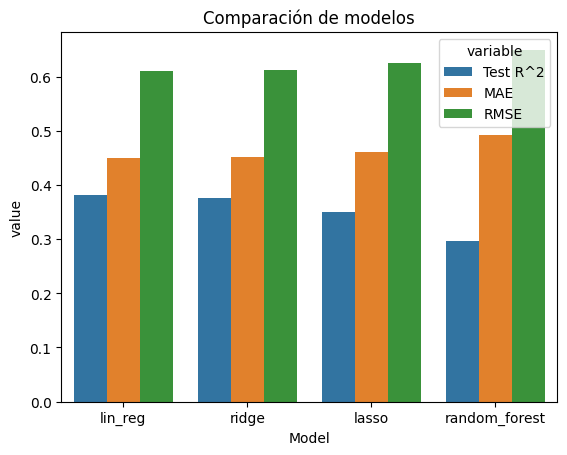

In [24]:
melted = df_results.melt(id_vars='Model', value_vars=['Test R^2', 'MAE', 'RMSE'])
sns.barplot(data=melted, x='Model', y='value', hue='variable')
plt.title('Comparación de modelos')
plt.show()

Según lo que pretendía plantear, estos resultados no son demasiado positivos. Es posible que haya que refinar los datos y tener otra clase de datos en cuenta, cosas que puedan estar afectando más a las ventas, como tener en cuenta periodos en los que se vende más u otra clase de información que no sea estrictamente referente al producto.